In [42]:
# ================== Load Libraries ===================

# --- Data Handling and Preprocessing ---
import pandas as pd  # For reading and managing datasets
import numpy as np  # For numerical computations and array handling
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting datasets
from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets
from sklearn.utils import resample  # For up/down sampling datasets
from sklearn.preprocessing import LabelEncoder # for data encoding

# --- Model Building ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Metrics and Evaluation ---
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)

# --- Plotting Libraries ---
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For advanced plotting (heatmaps, pairplots, etc.)
from matplotlib.lines import Line2D  # For advanced plotting (heatmaps, pairplots, etc.)

# --- Descriptive Statistics ---
import scipy.stats as stats  # For statistical functions like skew, kurtosis

# --- Blackhole Optimization Algorithm Libraries ---
import random  # For random number generation (if needed in Blackhole)
from collections import deque  # For managing experience replay (in case of RL-based models)
import math  # For mathematical operations (used in Blackhole algorithm)

# --- Additional Utilities ---
from sklearn.metrics import classification_report  # For classification metrics (if applicable)
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels if needed

# --- For saving model ---
from tensorflow.keras.models import load_model  # To save and load trained models


In [43]:
# Load dataset from the file path
file_path = '/Users/administrator/Desktop/All desktop-data/Dr.Ali/dataset/Dataset and Code/Dataset/iot_smart_city_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to inspect it
print(data.head())


    timestamp      device_id    device_type  uptime_hours  \
0  2021-03-31  DID_device_82  Type_sensor_a             6   
1  2021-04-14  DID_device_15  Type_sensor_a            19   
2  2021-10-10   DID_device_4  Type_sensor_c            14   
3  2021-06-01  DID_device_95  Type_sensor_a            10   
4  2021-12-24  DID_device_36  Type_sensor_b             7   

   battery_capacity_mAh  energy_consumption_mAh  temperature_C  \
0                  1299               96.872063      26.892357   
1                  4656              306.761532      26.564314   
2                  1050              226.034813      23.504291   
3                  2653              161.453438      31.595493   
4                  1698              113.017407      33.857801   

   humidity_percent  air_quality_index  motion_events  light_intensity_lux  \
0         82.600927                181             41           979.741226   
1         82.447369                481             53          1049.869784   
2 

In [44]:
# Rename columns using abbreviations
rename_dict = {
    'timestamp': 'TS',
    'device_id': 'DID',
    'device_type': 'Type',
    'uptime_hours': 'UPU',
    'battery_capacity_mAh': 'BC',
    'energy_consumption_mAh': 'EC',
    'temperature_C': 'Temp',
    'humidity_percent': 'Hum',
    'air_quality_index': 'AQI',
    'motion_events': 'ME',
    'light_intensity_lux': 'Lux',
    'noise_level_dB': 'NL',
    'co2_emissions_ppm': 'CO2',
    'wind_speed_m_s': 'WS',
    'precipitation_mm_h': 'Precip',
    'traffic_density_vehicles_h': 'TDV',
    'noise_pollution_level_dB': 'NPL',
    'anomaly': 'Anom'
}

data.rename(columns=rename_dict, inplace=True)



In [46]:
# Check for missing values
print("Missing values before cleaning:\n", data.isna().sum())

# Handle missing values (using mean for numerical columns and mode for categorical ones)
numerical_columns = ['UPU', 'BC', 'EC', 'Temp', 'Hum', 'AQI', 'ME', 'Lux', 'NL', 'CO2', 'WS', 'Precip', 'TDV', 'NPL']
categorical_columns = ['DID', 'Type']

for col in numerical_columns:
    data[col] = data[col].fillna(data[col].mean())  # Impute with mean for numerical columns



Missing values before cleaning:
 TS        0
DID       0
Type      0
UPU       0
BC        0
EC        0
Temp      0
Hum       0
AQI       0
ME        0
Lux       0
NL        0
CO2       0
WS        0
Precip    0
TDV       0
NPL       0
Anom      0
dtype: int64


In [47]:
# --- Step 1: Check for NaN values in the original dataset before cleaning ---
print("NaN values before cleaning in the original dataset:")
print(data.isna().sum())  # Print the count of NaN values in each column



NaN values before cleaning in the original dataset:
TS        0
DID       0
Type      0
UPU       0
BC        0
EC        0
Temp      0
Hum       0
AQI       0
ME        0
Lux       0
NL        0
CO2       0
WS        0
Precip    0
TDV       0
NPL       0
Anom      0
dtype: int64


In [48]:
# Identify categorical variables (object or category types)
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Print the categorical columns
print(f"Categorical columns: {categorical_columns}")



Categorical columns: Index(['TS', 'DID', 'Type'], dtype='object')


In [49]:
# List to hold binary and multilabel variables
binary_variables = []
multilabel_variables = []

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Add 'Anom' explicitly as binary if not already captured
binary_variables.append('Anom')

# Loop through the categorical columns and classify them
for col in categorical_columns:
    unique_values = data[col].nunique()  # Get the number of unique values in the column
    if unique_values == 2:
        binary_variables.append(col)  # Binary variable
    elif unique_values > 2:
        multilabel_variables.append(col)  # Multilabel (multiclass) variable

# Check binary variables
print("Binary variables:", binary_variables)

# Check multilabel (multiclass) variables
print("Multilabel (multiclass) variables:", multilabel_variables)


Binary variables: ['Anom']
Multilabel (multiclass) variables: ['TS', 'DID', 'Type']


In [50]:
# Assuming 'data' is your dataframe

# --- Step 1: Identify the multiclass columns (TS, DID, Type) ---
multiclass_columns = ['TS', 'DID', 'Type']  # List of multiclass columns

# --- Step 2: Count unique classes in each multiclass column ---
for col in multiclass_columns:
    unique_classes = data[col].nunique()  # Count unique classes in each column
    print(f"Number of unique classes in '{col}': {unique_classes}")


Number of unique classes in 'TS': 364
Number of unique classes in 'DID': 100
Number of unique classes in 'Type': 3


Class counts for 'Type':
Type
Type_sensor_c    20075
Type_sensor_a    20040
Type_sensor_b    19885
Name: count, dtype: int64


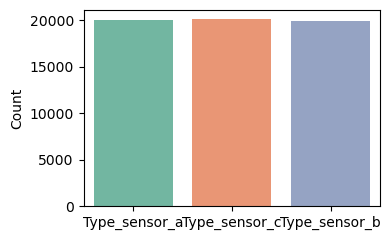

Class counts for 'Anom':
Anom
1    30011
0    29989
Name: count, dtype: int64


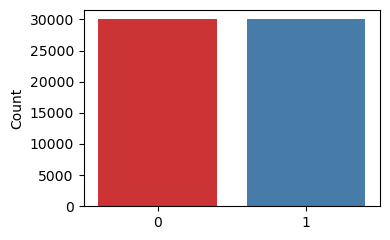

In [52]:
# --- Step 1: Count the classes in the 'Type' variable ---
type_class_counts = data['Type'].value_counts()  # Count unique classes in 'Type'
print(f"Class counts for 'Type':\n{type_class_counts}")

# --- Step 2: Plot the distribution of the 'Type' classes ---
plt.figure(figsize=(4, 2.5))
ax = sns.countplot(data=data, x='Type', palette='Set2')
ax.set(xlabel='')  # Remove the x-axis label for 'Type'
plt.ylabel('Count')  # Only display the y-axis label
plt.tight_layout()
plt.show()

# --- Step 3: Count the classes in the 'Anom' variable (binary classification) ---
anom_class_counts = data['Anom'].value_counts()  # Count unique classes in 'Anom'
print(f"Class counts for 'Anom':\n{anom_class_counts}")

# --- Step 4: Plot the distribution of the 'Anom' classes (binary) ---
plt.figure(figsize=(4, 2.5))
ax = sns.countplot(data=data, x='Anom', palette='Set1')
ax.set(xlabel='')  # Remove the x-axis label for 'Anom'
plt.ylabel('Count')  # Only display the y-axis label
plt.tight_layout()
plt.show()


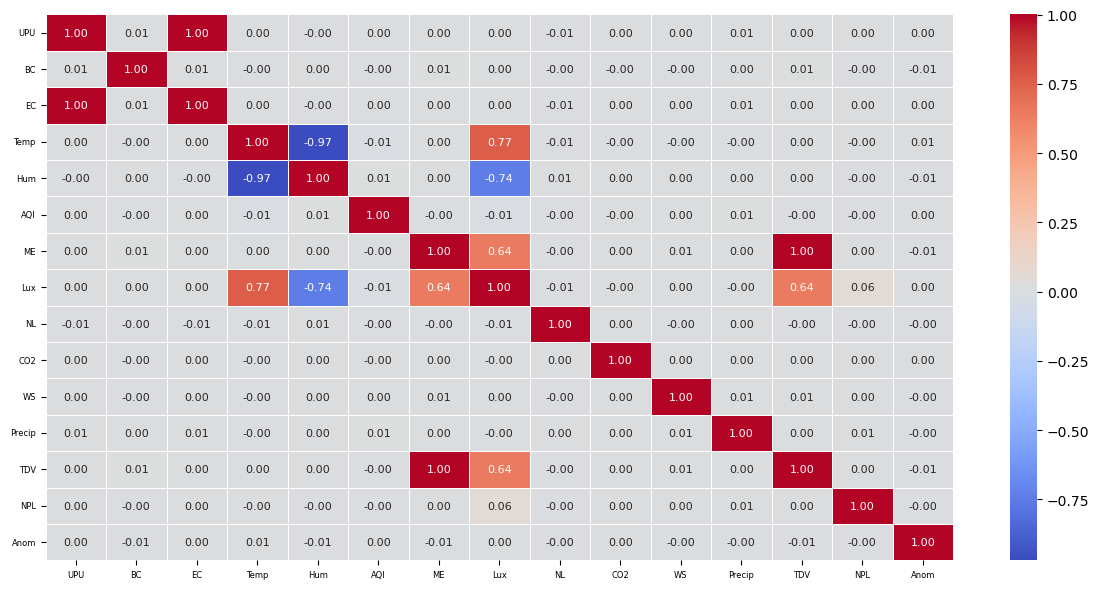

In [53]:
data.rename(columns=rename_dict, inplace=True)

# Convert CO2 to numeric, coerce errors to NaN
data["CO2"] = pd.to_numeric(data["CO2"], errors="coerce")

# Drop rows where CO2 is NaN
data = data.dropna(subset=["CO2"])

# Select only numeric columns for correlation
numeric_features = data.select_dtypes(include=[np.number]).columns

# Compute Pearson correlation matrix
correlation_matrix = data[numeric_features].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(fontsize=6, rotation=0)  # Horizontal x-axis labels
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

In [54]:
# Check column names of the resampled dataset
print(resampled_data.columns)


Index(['TS', 'DID', 'Type', 'UPU', 'BC', 'Temp', 'Hum', 'AQI', 'ME', 'Lux',
       'NL', 'CO2', 'WS', 'Precip', 'TDV', 'NPL', 'Anom'],
      dtype='object')


/Users/administrator/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/administrator/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/administrator/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/administrator/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

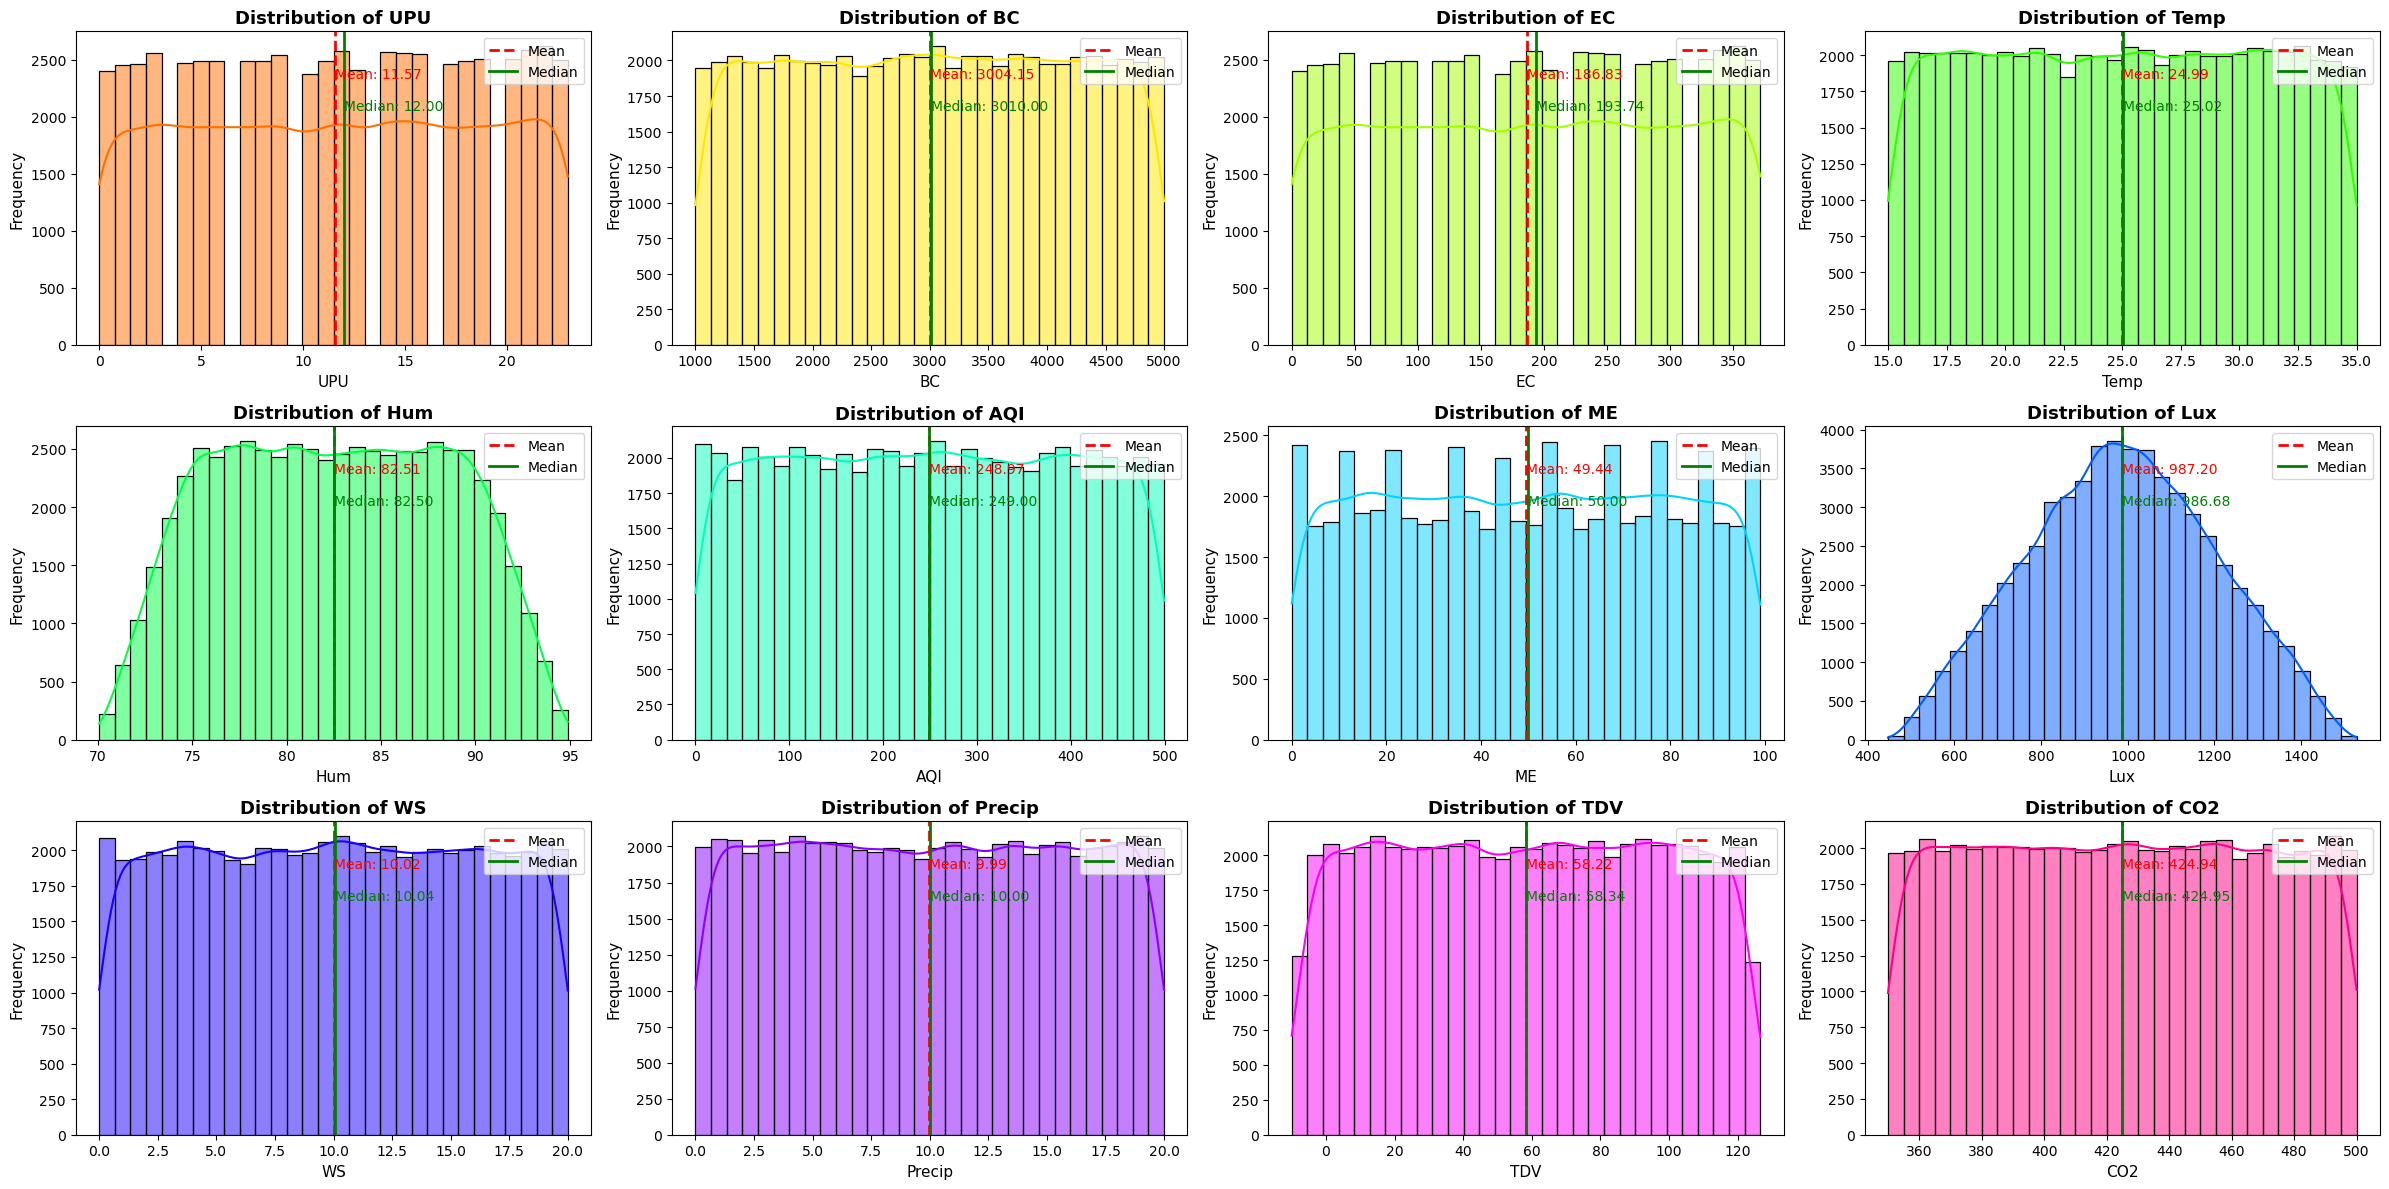

In [55]:
# Step 2: Define the 12 numeric features to include (with anomaly removed and precipitation_mm_h included)
features = [
    'UPU',  # Renamed from 'uptime_hours'
    'BC',   # Renamed from 'battery_capacity_mAh'
    'EC',   # Renamed from 'energy_consumption_mAh'
    'Temp', # Renamed from 'temperature_C'
    'Hum',  # Renamed from 'humidity_percent'
    'AQI',  # Renamed from 'air_quality_index'
    'ME',   # Renamed from 'motion_events'
    'Lux',  # Renamed from 'light_intensity_lux'
    'WS',   # Renamed from 'wind_speed_m_s'
    'Precip', # Renamed from 'precipitation_mm_h'
    'TDV',  # Renamed from 'traffic_density_vehicles_h'
    'CO2'   # Renamed from 'co2_emissions_ppm'
]

# Step 3: Setup color palette
color_palette = sns.color_palette("hsv", len(features))

# Step 4: Create subplots (3 rows x 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.flatten()

# Step 5: Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    data_feature = data[feature].dropna()  # Using the existing 'data' variable

    mean_val = data_feature.mean()
    median_val = data_feature.median()

    sns.histplot(data_feature, kde=True, color=color_palette[i], edgecolor="black", ax=ax, bins=30)

    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(median_val, color='green', linestyle='-', linewidth=2)

    ax.text(mean_val, ax.get_ylim()[1]*0.85, f'Mean: {mean_val:.2f}', color='red', fontsize=10)
    ax.text(median_val, ax.get_ylim()[1]*0.75, f'Median: {median_val:.2f}', color='green', fontsize=10)

    ax.set_title(f'Distribution of {feature}', fontsize=13, fontweight='bold')
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)

    handles = [
        Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Mean'),
        Line2D([0], [0], color='green', linestyle='-', linewidth=2, label='Median')
    ]
    ax.legend(handles=handles, loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()